# Human Activity Detection (HAR)

## Task 1 : Exploratory Data Analysis (EDA) [3 marks]

### Importing requried libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from watermark  import watermark

In [2]:
sys.path.insert(0, os.path.abspath('..'))
from latexify import latexify, format_axes
latexify()

# Retina mode
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

### Print package versions

In [3]:
%reload_ext watermark
%watermark -a "E. Díaz" -u -n -t -z -m -v -p numpy,pandas,matplotlib,sklearn,seaborn

Author: E. Díaz

Last updated: Tue Aug 27 2024 13:35:25India Standard Time

Python implementation: CPython
Python version       : 3.12.4
IPython version      : 8.26.0

numpy     : 2.0.1
pandas    : 2.2.2
matplotlib: 3.9.2
sklearn   : 1.5.1
seaborn   : 0.13.2

Compiler    : MSC v.1940 64 bit (AMD64)
OS          : Windows
Release     : 11
Machine     : AMD64
Processor   : Intel64 Family 6 Model 186 Stepping 2, GenuineIntel
CPU cores   : 20
Architecture: 64bit



### Loading the training and testing sets

In [4]:
X_train = np.load('../SavedDataset/Raw/X_train.npy')
X_test = np.load('../SavedDataset/Raw/X_test.npy')
y_train = np.load('../SavedDataset/Raw/y_train.npy')
y_test = np.load('../SavedDataset/Raw/y_test.npy')

print("Training data shape: ",X_train.shape)
print("Training labels shape: ",y_train.shape)
print("Testing data shape: ",X_test.shape)
print("Testing labels shape: ",y_test.shape)

Training data shape:  (126, 500, 3)
Training labels shape:  (126,)
Testing data shape:  (54, 500, 3)
Testing labels shape:  (54,)


### Data Cleaning

In [5]:
# check for duplicated data, numpy doesnt have duplicated() function
def duplicates(data):
    return len(data) - len(np.unique(data, axis=0))

print("Number of duplicated samples in training data: ", duplicates(X_train))
print("Number of duplicated samples in testing data: ", duplicates(X_test))


Number of duplicated samples in training data:  0
Number of duplicated samples in testing data:  0


In [6]:
def null_values(data):
    return np.isnan(data).sum()

print("Number of NaN/Null values in training data: ", null_values(X_train))
print("Number of NaN/Null values in testing data: ", null_values(X_test))

Number of NaN/Null values in training data:  0
Number of NaN/Null values in testing data:  0


### Question 1

Q1. Plot the waveform for one sample data from each activity class. Are you able to see any difference/similarities between the activities? You can plot a subplot having 6 columns to show differences/similarities between the activities. Do you think the model will be able to classify the activities based on the data?

### Solution:

The following 6x3 subplot shows the accelerometer data for the first person:

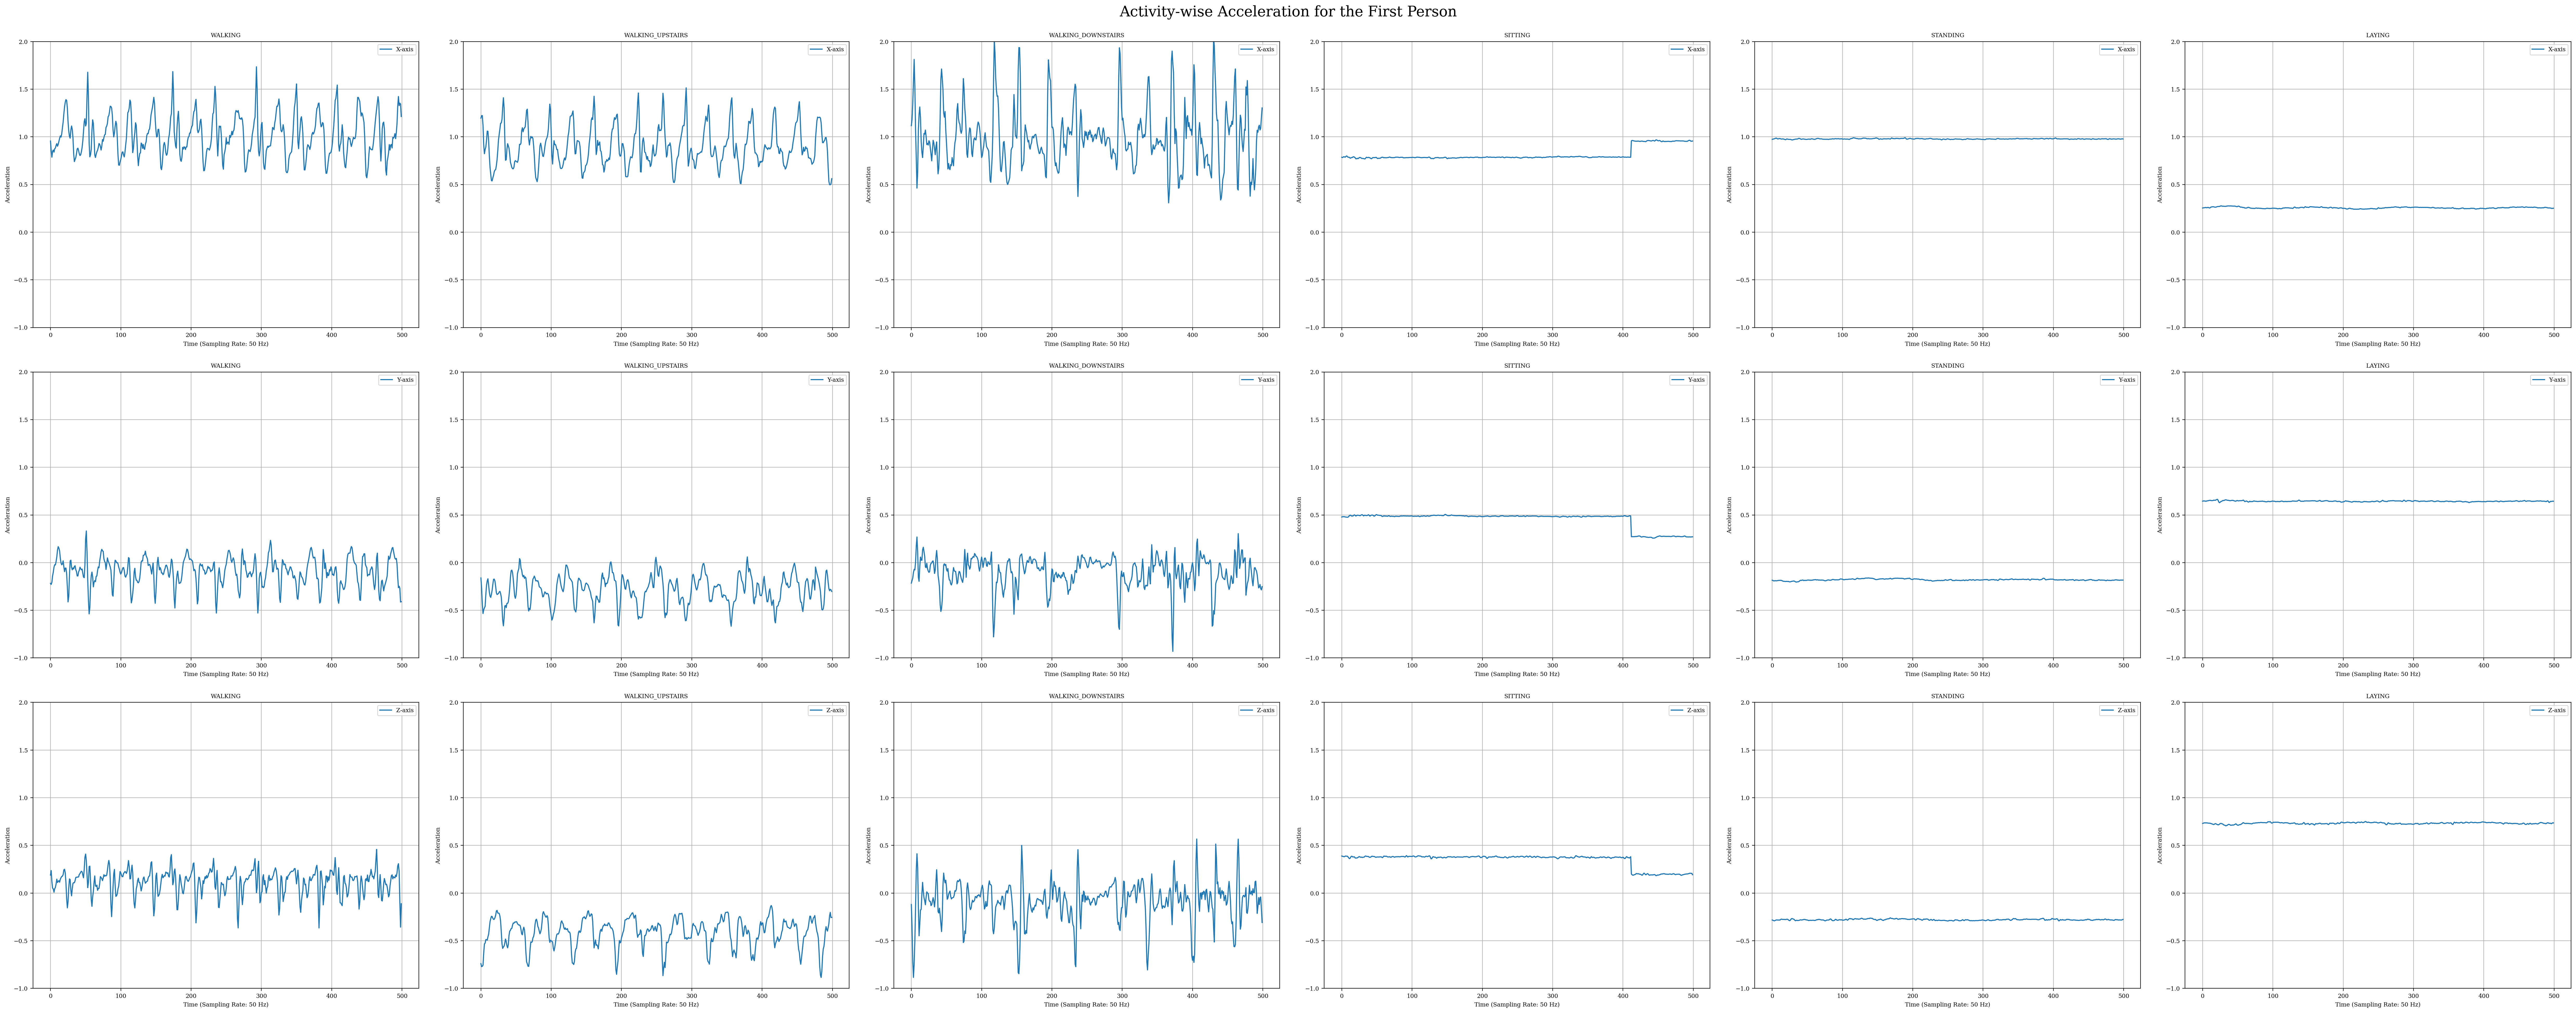

In [7]:
activity_classes = {"WALKING":1,"WALKING_UPSTAIRS":2,"WALKING_DOWNSTAIRS":3,"SITTING":4,"STANDING":5,"LAYING":6}
directions = ["X-axis","Y-axis","Z-axis"]

standard_color = 'tab:blue'
fig, axes = plt.subplots(3, 6, figsize=(50,20))
fig.suptitle("Activity-wise Acceleration for the First Person", fontsize=20)

for activity_class, i in activity_classes.items():
    acc_data = X_train[y_train==i]   # get the accelerometer data for the class
    acc_data_p1 = acc_data[0]        # get the accelerometer data for the first person

    for j, direction in enumerate(directions):
        axes[j,i-1].set_title(activity_class)
        axes[j,i-1].plot(acc_data_p1[:,j], label=direction)
        axes[j,i-1].legend()
        axes[j,i-1].set_xlabel("Time (Sampling Rate: 50 Hz)")
        axes[j,i-1].set_ylabel("Acceleration")
        axes[j,i-1].set_ylim(-1, 2)
        axes[j,i-1].grid()


plt.tight_layout(pad=3.0)
plt.show()

The different activities show noticeable differences in their directional waveforms. The range of acceleration and peaks differ for all the activies. At first glance, we can observe that the dynamic activies like walking, walking upstairs, and walking downstairs have multiple peaks that vary in width and height. This makes them stand out from the static activities like sitting, standing, and laying, which have smoother waveforms with less variations.

So far, we have learnt Decision Trees and Random Forest in the course. Both of these models will not be able to accurately classify the activities because these models dont perform well on sequential time-series data having temporal dependencies as they dont consider the order in which activities are performed or samples are taken. Although, we can perform a simple classification between the dynamic and static activities, if we add additional features like mean, median, max acceleration and variance.

### Question 2

Q2. Do you think we need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities (walking, walking downstairs, walking upstairs)? 

Look at the linear acceleration $( acc_x^2 + acc_y^2 + acc_z^2 )$ for each activity and justify your answer.


### Solution:

We can find the linear acceleration $(acc_x^2 + acc_y^2 + acc_z^2)$ for each activity in the following manner:

Linear Acceleration Training Data Shape:  (126, 500)
Linear Acceleration Testing Data Shape:  (54, 500)
Linear acceleration data for subject 1


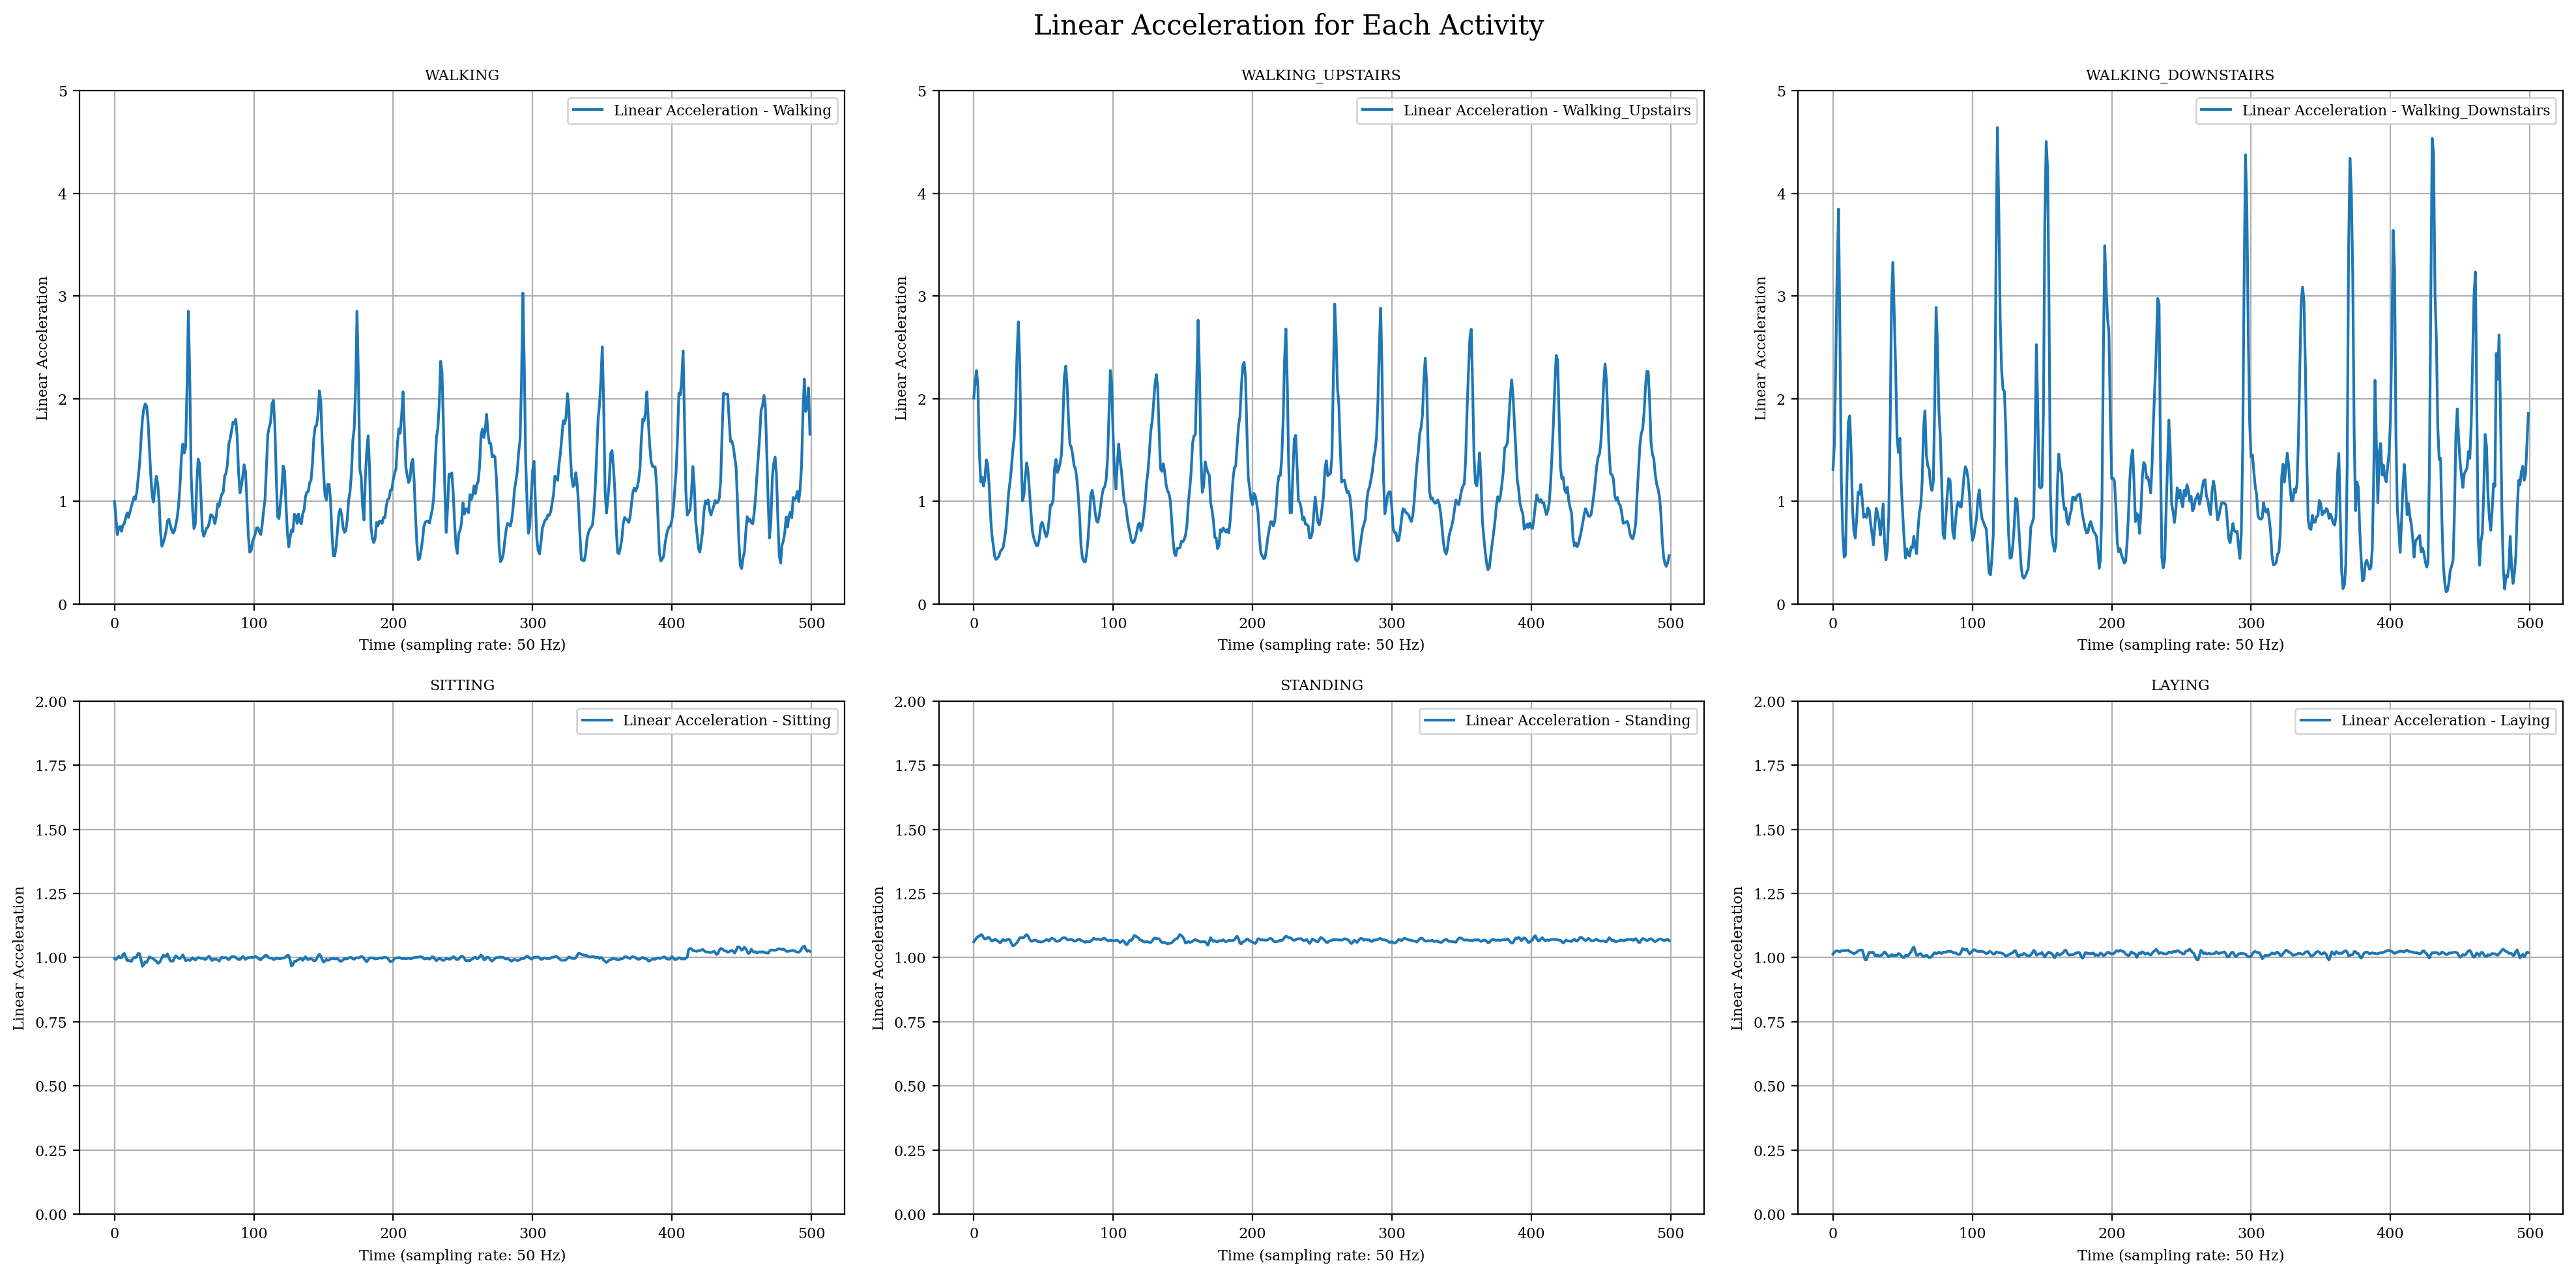

Linear acceleration data for subject 2


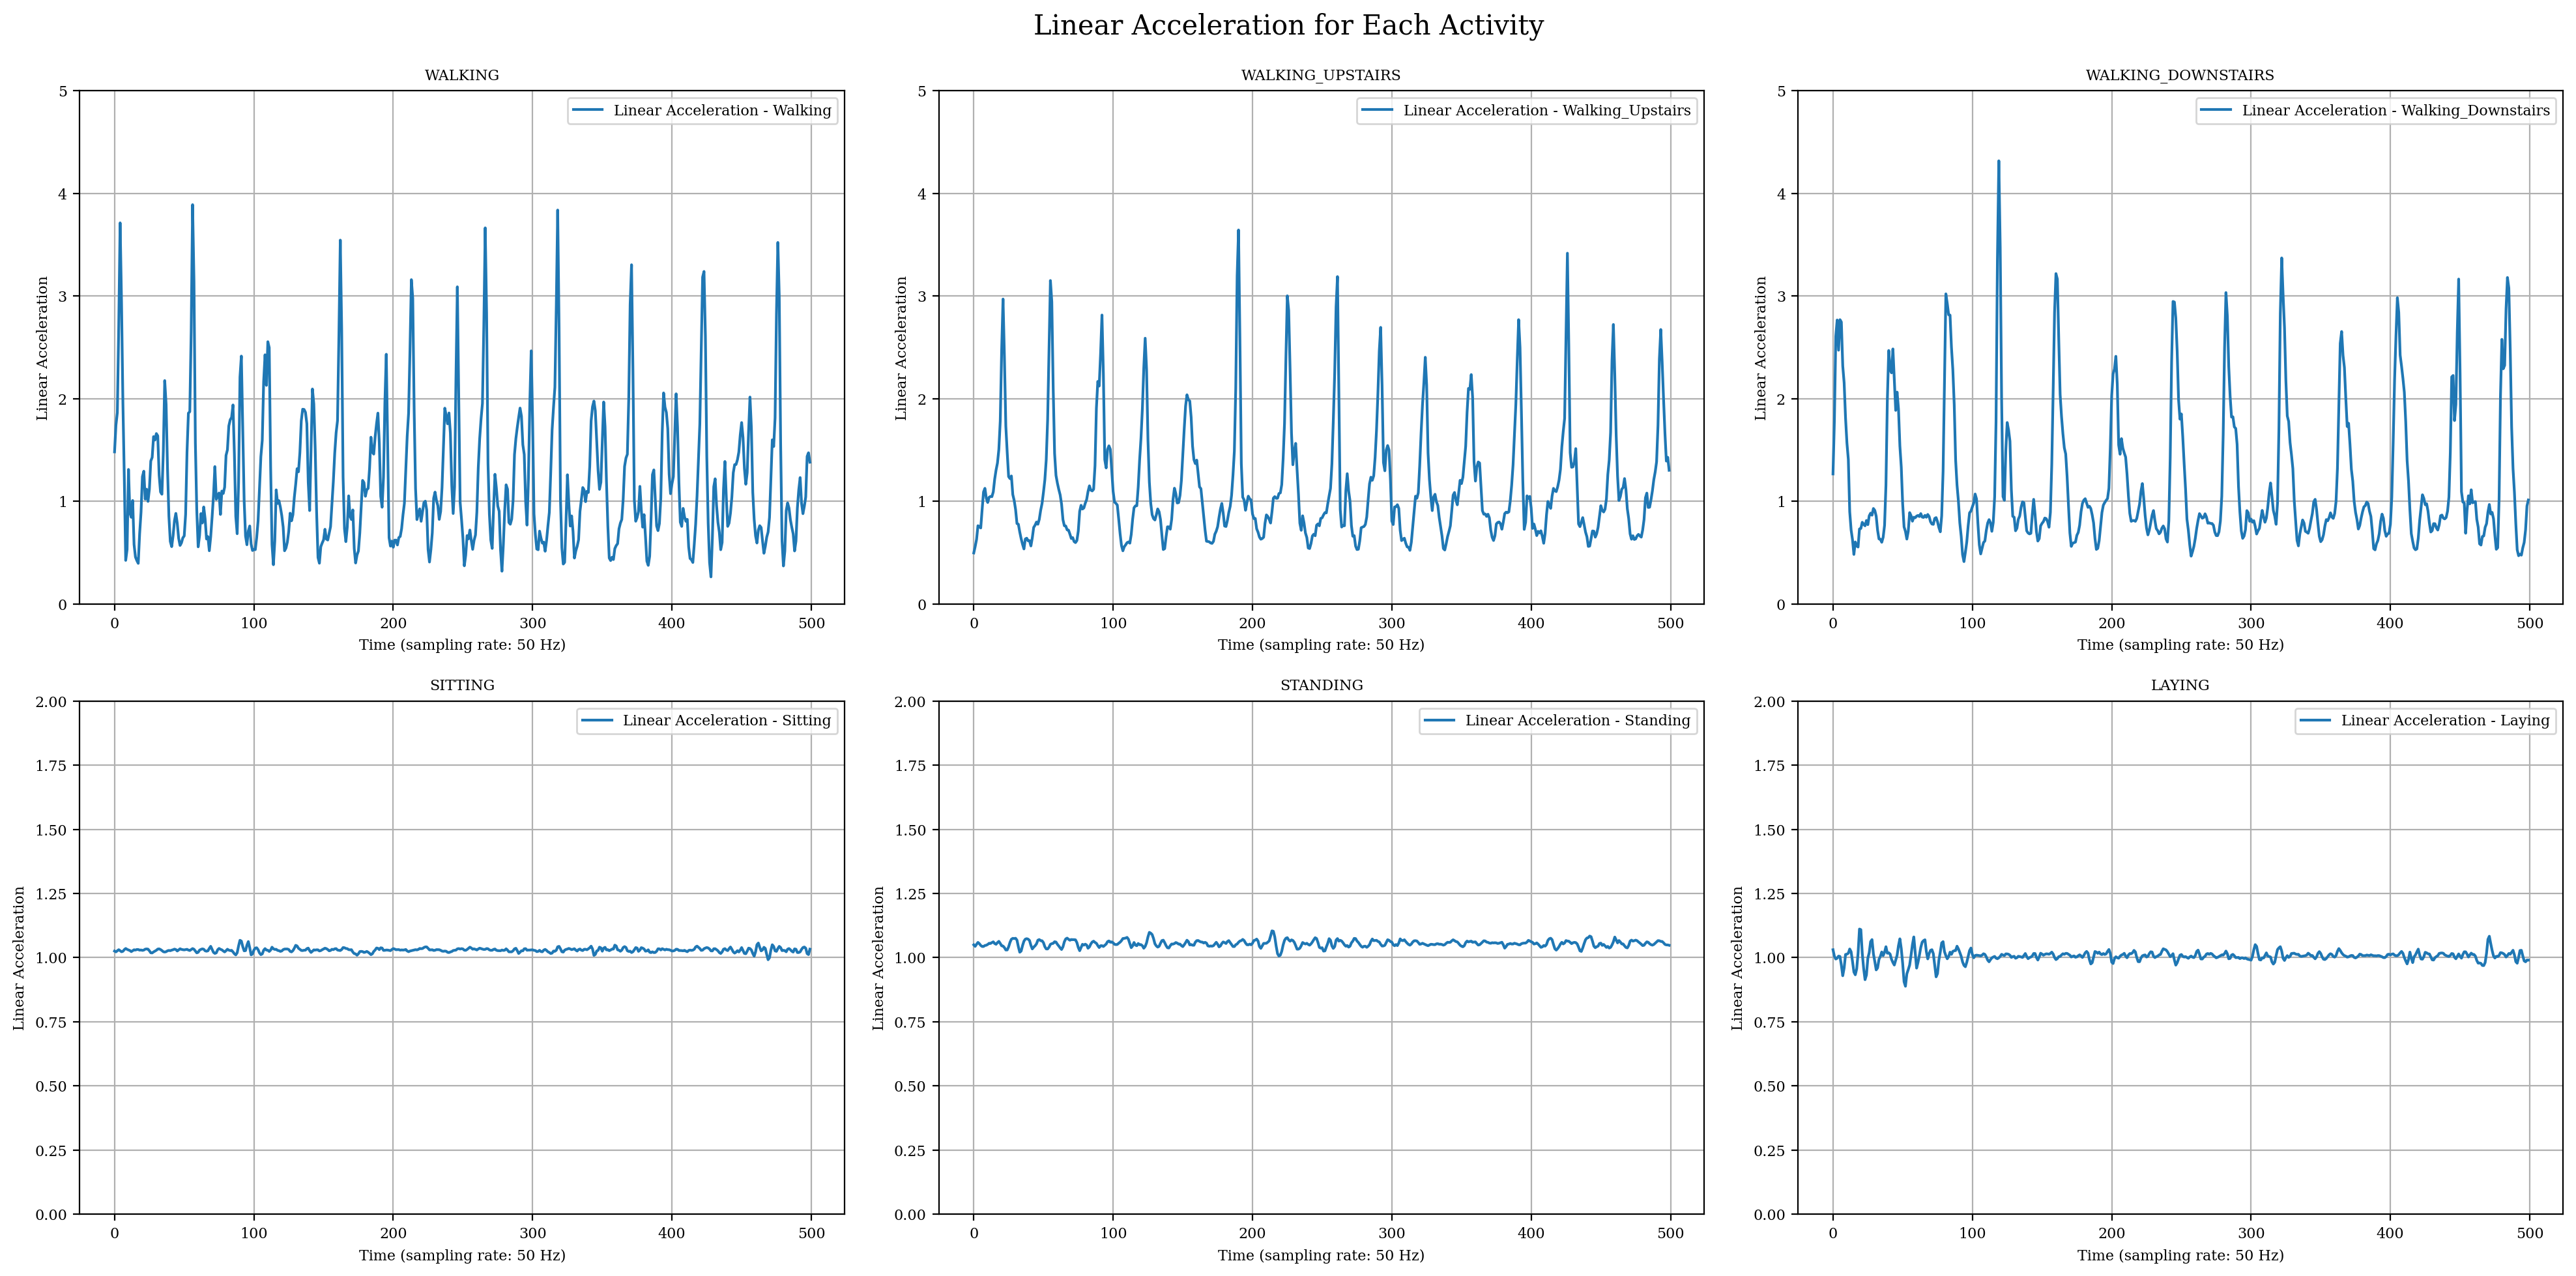

In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Calculate linear acceleration for training and testing data
linear_acceleration_train = X_train[:,:,0]**2 + X_train[:,:,1]**2 + X_train[:,:,2]**2
linear_acceleration_test = X_test[:,:,0]**2 + X_test[:,:,1]**2 + X_test[:,:,2]**2
print("Linear Acceleration Training Data Shape: ", linear_acceleration_train.shape)
print("Linear Acceleration Testing Data Shape: ", linear_acceleration_test.shape)

def plot_linear_acceleration(activity_classes, linear_acceleration_train, y_train, subject_id):
    print("="*150)
    print("Linear acceleration data for subject", subject_id)
    fig, axes = plt.subplots(2, 3, figsize=(20, 10))
    fig.suptitle("Linear Acceleration for Each Activity", fontsize=15)

    axes = axes.flatten()

    for activity_class, i in activity_classes.items():
        acceleration_data = linear_acceleration_train[y_train == i][subject_id-1]

        ax = axes[i-1]
        ax.plot(acceleration_data, label=f'Linear Acceleration - {str.title(activity_class)}')
        ax.set_title(f'{activity_class}')
        ax.set_xlabel('Time (sampling rate: 50 Hz)')
        ax.set_ylabel('Linear Acceleration')
        # Set the y-axis limits for better visualization
        if i<4:
            ax.set_ylim(0, 5)
        else:
            ax.set_ylim(0, 2)          
        ax.legend()
        ax.grid()

    plt.tight_layout(pad=2.0)
    plt.show()


# Plot linear acceleration for the first person
plot_linear_acceleration(activity_classes, linear_acceleration_train, y_train, 1)

# Plot linear acceleration for the second person
plot_linear_acceleration(activity_classes, linear_acceleration_train, y_train, 2)


No, we don't need a machine learning model to differentiate between static activities (laying, sitting, standing) and dynamic activities (walking, walking downstairs, walking upstairs). We can visually distinguish between static and dynamic activities by looking at their linear acceleration graphs and the minimum and maximum values of linear acceleration. The linear acceleration for static activities is almost constant at around 1, while for dynamic activities, it continuously varies with higher peaks. We can predict the activity using simple conditional statements based on the maximum and minimum acceleration values.

Although, if computational resources are available, a decision tree can be used to classify between static and dynamic activities by training it on the linear acceleration data.

### Question 3

Q3. Visualize the data using PCA.

1. Use PCA (Principal Component Analysis) on Total Acceleration $(acc_x^2+acc_y^2+acc_z^2)$ to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities.

2.  Next, use [TSFEL](https://tsfel.readthedocs.io/en/latest/) ([a featurizer library](https://github.com/fraunhoferportugal/tsfel)) to create features (your choice which ones you feel are useful) and then perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

3.  Now use the features provided by the dataset and perform PCA to obtain two features. Plot a scatter plot to visualize different class of activities.

4.  Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data? 

### Solution:

Importing the StandardScaler() and PCA() functions from scikit-learn.

In [9]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

#### 3.1 Using PCA (Principal Component Analysis) on Total Acceleration to compress the acceleration timeseries into two features and plot a scatter plot to visualize different class of activities.

Shape of the original data:  (126, 500)
Shape of the PCA transformed data:  (126, 2)


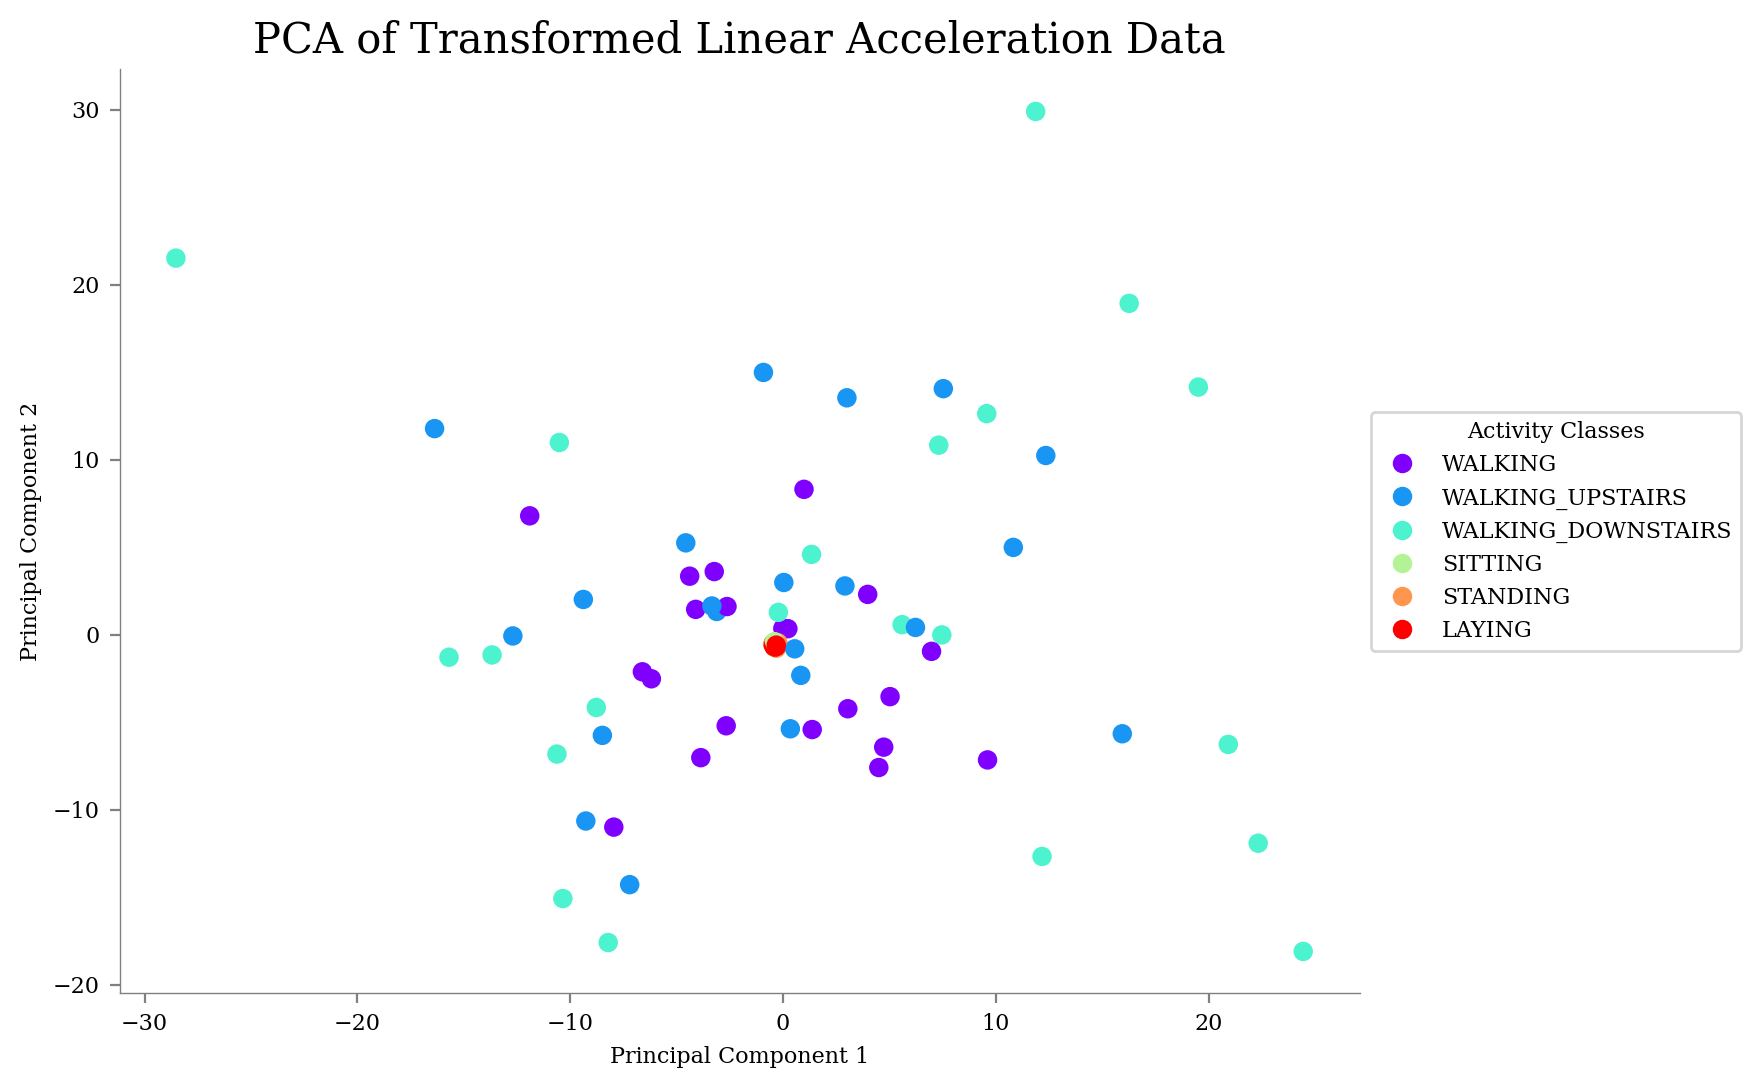

In [10]:
# standardizing the data before applying PCA
scaler = StandardScaler()
linear_acceleration_train_scaled = scaler.fit_transform(linear_acceleration_train)

# applying PCA
accelerometer_pca = PCA(n_components=2)
linear_acceleration_train_pca = accelerometer_pca.fit_transform(linear_acceleration_train_scaled)

print("Shape of the original data: ", linear_acceleration_train.shape)
print("Shape of the PCA transformed data: ", linear_acceleration_train_pca.shape)

plt.figure(figsize=(8, 6))
scatter = plt.scatter(linear_acceleration_train_pca[:, 0], linear_acceleration_train_pca[:, 1], c=y_train, cmap='rainbow')
format_axes(plt.gca())
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Transformed Linear Acceleration Data", fontsize=15)
plt.legend(handles=scatter.legend_elements()[0], labels=activity_classes.keys(), title="Activity Classes", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#### 3.2 Using [TSFEL](https://tsfel.readthedocs.io/en/latest/) to extract features from the raw accelerometer data. The features to be extracted include:
- Absolute Energy
- Mean Absolute Deviation
- Peak-to-Peak Distance
- Root Mean Square (RMS)
- Autocorrelation
- Variance
- Mean
    
then performing PCA on these features to obtain 2 principle features and then plot them using a scatter plot to visualize different classes of activies

In [22]:
import tsfel

# Extract features using TSFEL
cfg = tsfel.get_features_by_domain()  # Get all features by default
X_train_tsfel = tsfel.time_series_features_extractor(cfg, X_train, verbose=1,fs =50)
X_test_tsfel = tsfel.time_series_features_extractor(cfg, X_test, verbose=1,fs =50)
'''
verbose parameter controls the amount of information that is printed out during the execution of the function.
verbose=0: Suppresses all output. No messages will be printed.
verbose=1: Prints basic information, often minimal progress updates.
verbose=2 and above: Prints more detailed information, including potentially extensive logs or debug information.

fs : sampling frequency
'''

'''
When you call tsfel.get_features_by_domain(), it returns a configuration (cfg) that specifies which features to extract from your time series data.
The cfg variable holds the configuration that tells TSFEL which features to compute. This configuration can be customized or retrieved for specific domains.
When you call tsfel.get_features_by_domain(), it retrieves a default configuration that includes a wide variety of features from all domains (time, frequency, and statistical).

Time-domain features: Mean, standard deviation, kurtosis, skewness, etc.
Frequency-domain features: Spectral entropy, power spectral density, etc.
Statistical features: Quantiles, autocorrelation, etc

'''
print("Shape of train data after performing feature creation using tsfel:",X_train_tsfel.shape)
print("Shape of test data after performing feature creation using tsfel:",X_test_tsfel.shape)
print(X_train_tsfel.columns)

*** Feature extraction started ***



*** Feature extraction finished ***
*** Feature extraction started ***



*** Feature extraction finished ***
Shape of train data after performing feature creation using tsfel: (126, 1152)
Shape of test data after performing feature creation using tsfel: (54, 1152)
Index(['0_Absolute energy', '0_Area under the curve', '0_Autocorrelation',
       '0_Average power', '0_Centroid', '0_ECDF Percentile Count_0',
       '0_ECDF Percentile Count_1', '0_ECDF Percentile_0',
       '0_ECDF Percentile_1', '0_ECDF_0',
       ...
       '2_Wavelet variance_0', '2_Wavelet variance_1', '2_Wavelet variance_2',
       '2_Wavelet variance_3', '2_Wavelet variance_4', '2_Wavelet variance_5',
       '2_Wavelet variance_6', '2_Wavelet variance_7', '2_Wavelet variance_8',
       '2_Zero crossing rate'],
      dtype='object', length=1152)


In [23]:
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing

# Highly correlated features are removed
corr_features = tsfel.correlated_features(X_train_tsfel, threshold=0.95)
X_train_tsfel_corr = X_train_tsfel.drop(corr_features, axis=1)
X_test_tsfel_corr = X_test_tsfel.drop(corr_features, axis=1)
print("Shape of train data after removing correlated features:",X_train_tsfel.shape)
print("Shape of test data after removing correlated features:",X_test_tsfel.shape)

# Remove low variance features
selector = VarianceThreshold(threshold = 0.1) # default is 0
X_train_tsfel_corr_var = selector.fit_transform(X_train_tsfel_corr)
X_test_tsfel_corr_var = selector.transform(X_test_tsfel_corr)
print("\nShape of train data after removing low variance features:",X_train_tsfel.shape)
print("Shape of test data after removing low variance features:",X_test_tsfel.shape)

Shape of train data after removing correlated features: (126, 1152)
Shape of test data after removing correlated features: (54, 1152)

Shape of train data after removing low variance features: (126, 1152)
Shape of test data after removing low variance features: (54, 1152)


In [24]:
# Normalising Features
scaler = preprocessing.StandardScaler()
X_train_tsfel_scaled = scaler.fit_transform(X_train_tsfel_corr_var)
X_test_tsfel_scaled = scaler.transform(X_test_tsfel_corr_var)

# Applying PCA
tsfel_pca = PCA(n_components=2)
X_train_tsfel_pca = tsfel_pca.fit_transform(X_train_tsfel_scaled)
X_test_tsfel_pca = tsfel_pca.transform(X_test_tsfel_scaled)

print("Training data shape after PCA: ",X_train_tsfel_pca.shape)
print("Testing data shape after PCA: ",X_test_tsfel_pca.shape)

Training data shape after PCA:  (126, 2)
Testing data shape after PCA:  (54, 2)


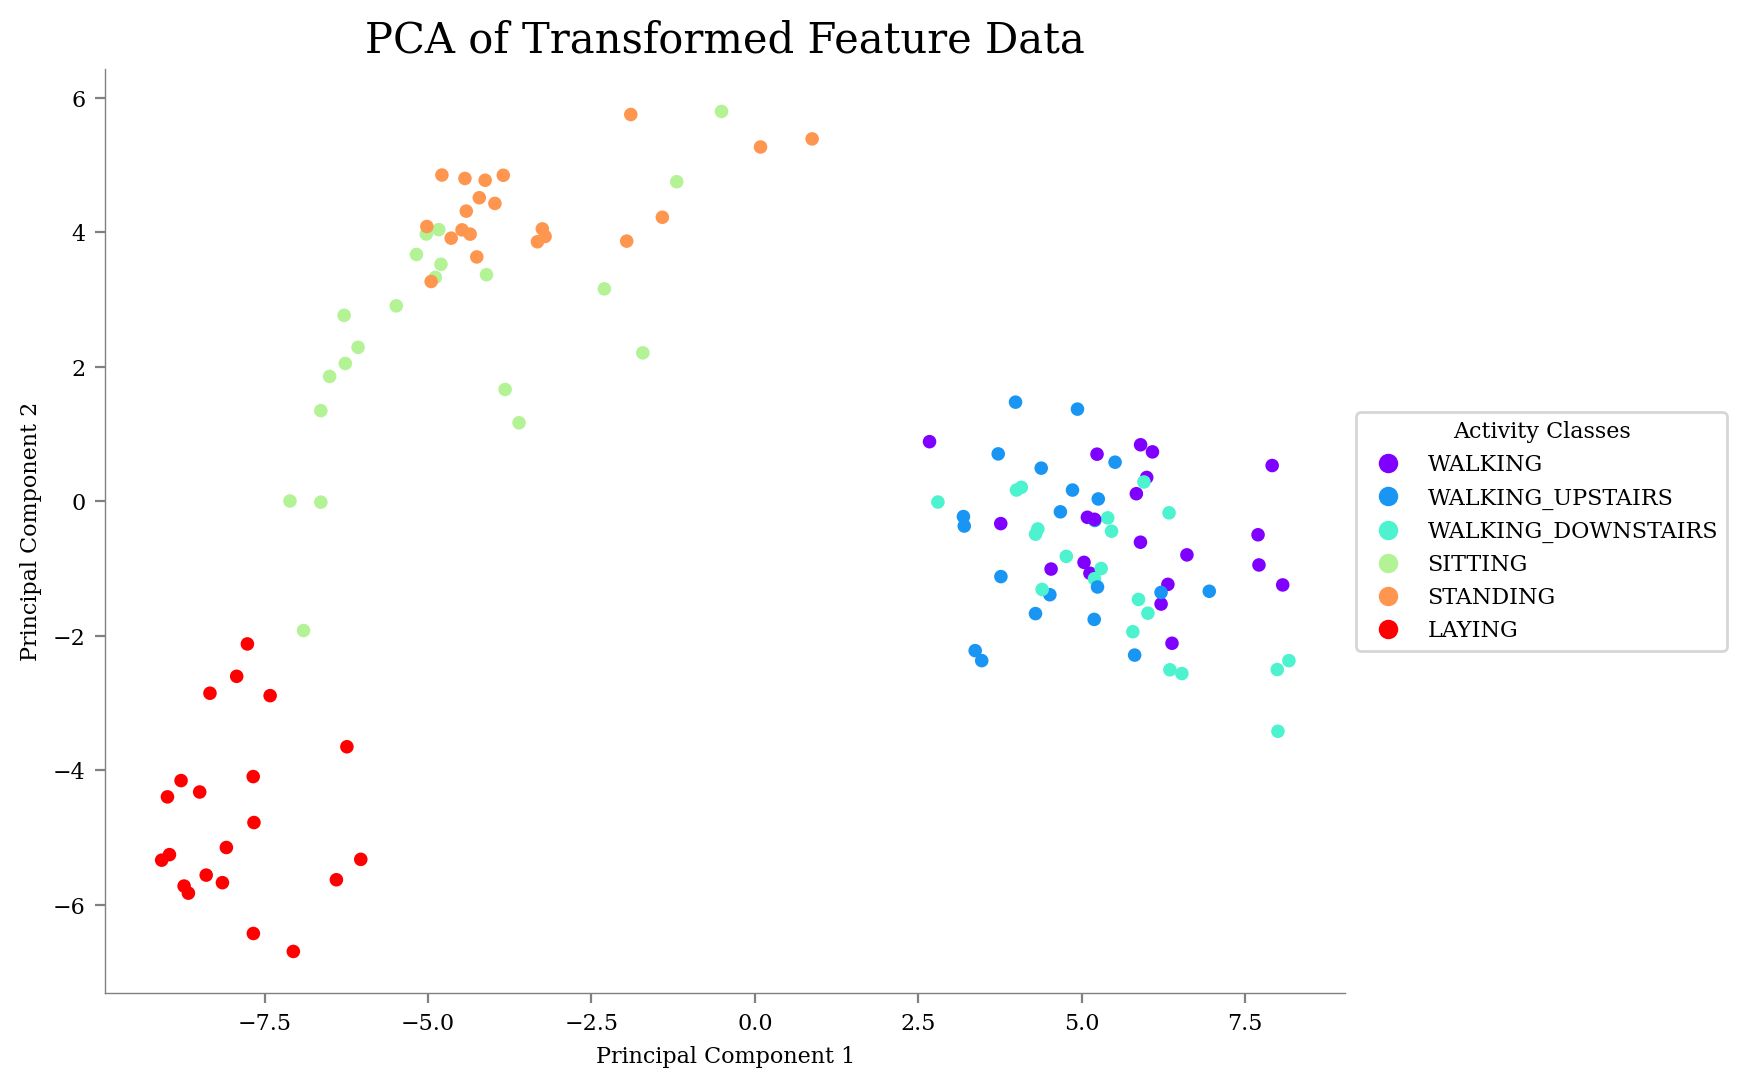

In [26]:
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown']

plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_train_tsfel_pca[:, 0], X_train_tsfel_pca[:, 1], c=y_train, cmap='rainbow', s=15)
format_axes(plt.gca())
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Transformed Feature Data", fontsize=15)
plt.legend(handles=scatter.legend_elements()[0], labels=activity_classes.keys(), title="Activity Classes", loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


#### 3.3 Using the features provided by the dataset, perform PCA to obtain two features and then plotting the data

In [33]:
UCI_X_train = np.load('../SavedDataset/direct/UCI_X_train.npy')
UCI_X_test = np.load('../SavedDataset/direct/UCI_X_test.npy')
UCI_y_train = np.load('../SavedDataset/direct/UCI_y_train.npy')
UCI_y_test = np.load('../SavedDataset/direct/UCI_y_test.npy')

print("Training data shape: ",UCI_X_train.shape)
print("Training labels shape: ",UCI_y_train.shape)
print("Testing data shape: ",UCI_X_test.shape)
print("Testing labels shape: ",UCI_y_test.shape)

Training data shape:  (7352, 561)
Training labels shape:  (7352, 1)
Testing data shape:  (2947, 561)
Testing labels shape:  (2947, 1)


In [16]:
scaler = StandardScaler()
UCI_X_train_scaled = scaler.fit_transform(UCI_X_train)
UCI_X_test_scaled = scaler.transform(UCI_X_test)

uci_pca = PCA(n_components=2)
UCI_X_train_pca = uci_pca.fit_transform(UCI_X_train_scaled)
UCI_X_test_pca = uci_pca.transform(UCI_X_test_scaled)

print("Training data shape after PCA: ",UCI_X_train_pca.shape)
print("Testing data shape after PCA: ",UCI_X_test_pca.shape)

Training data shape after PCA:  (7352, 2)
Testing data shape after PCA:  (2947, 2)


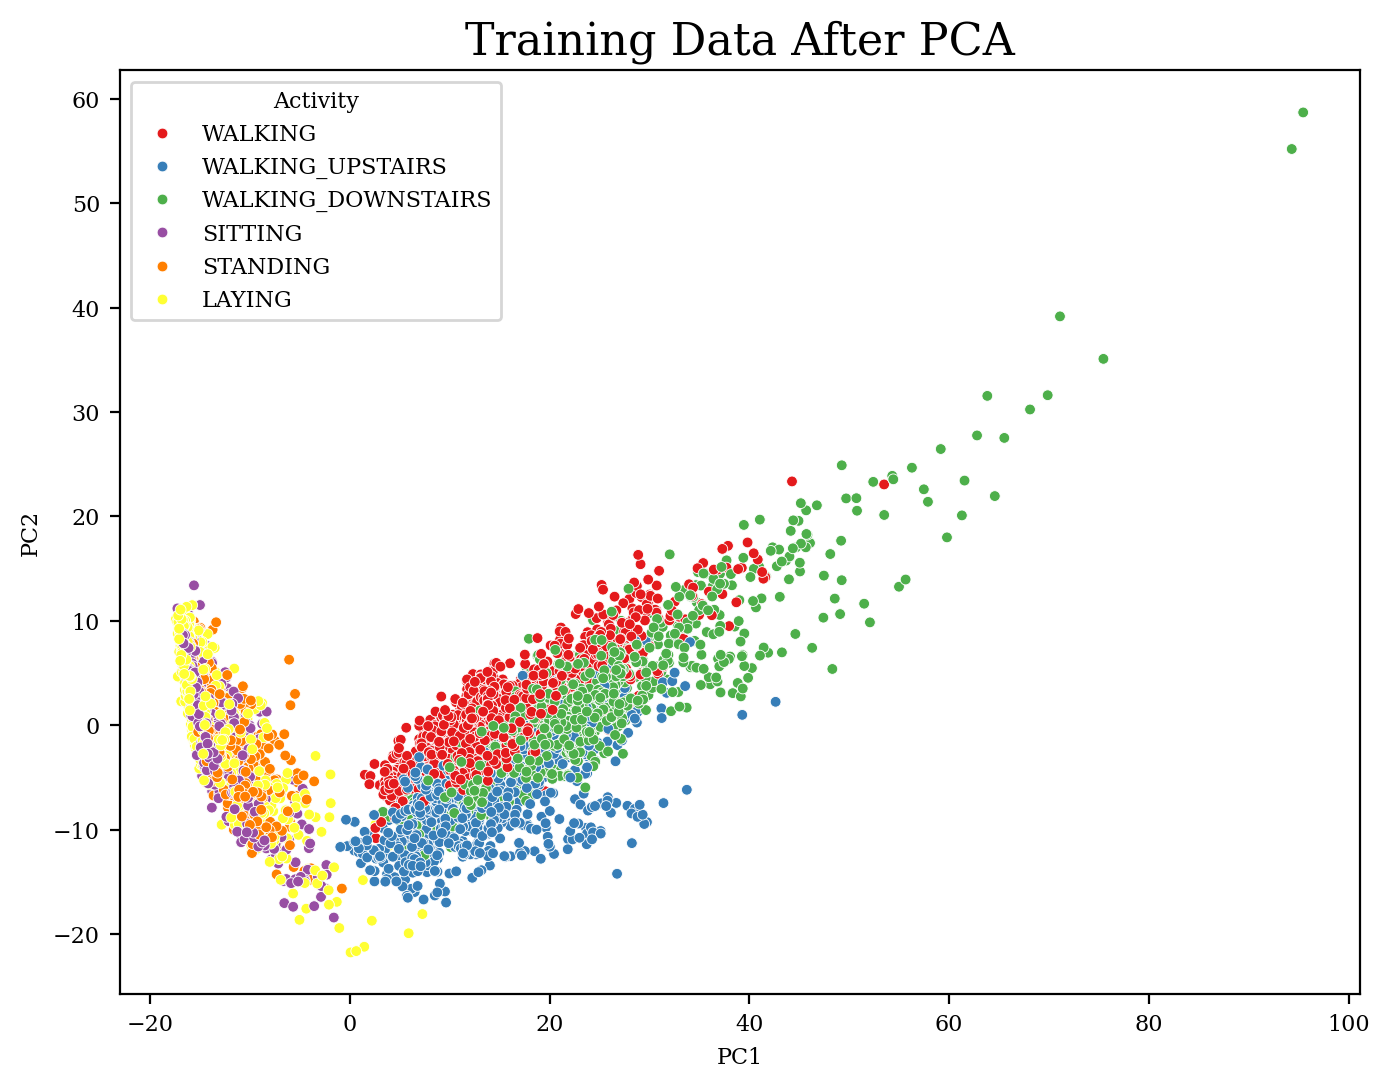

In [17]:
# plot the training data after PCA
df_train = pd.DataFrame(UCI_X_train_pca,columns=["PC1","PC2"])
df_train["Activity"] = UCI_y_train
df_train["Activity"] = df_train["Activity"].map({1:"WALKING",2:"WALKING_UPSTAIRS",3:"WALKING_DOWNSTAIRS",4:"SITTING",5:"STANDING",6:"LAYING"})

plt.figure(figsize=(8, 6))
sns.scatterplot(x="PC1", y="PC2", hue="Activity", data=df_train, palette="Set1", hue_order=["WALKING", "WALKING_UPSTAIRS", "WALKING_DOWNSTAIRS", "SITTING", "STANDING", "LAYING"], s=15)
plt.title("Training Data After PCA", fontsize=16)
plt.show()

#### 3.4 Compare the results of PCA on Total Acceleration, TSFEL and the dataset features. Which method do you think is better for visualizing the data?

**Solution:**

The first scatter plot indicates that all the static activities (sitting, standing, laying) overlap significantly around the origin, approximately at (0, 0). This clustering suggests that the static activities share similar characteristics in terms of linear acceleration. On the other hand, the dynamic activities (walking, walking upstairs, walking downstairs) are more spread out across the principal component space, reflecting their variability in linear acceleration.

.
.
.
.
.
.
.
.
.
.
.
.
.
.

### Q4. Calculate the correlation matrix of the features obtained by TSFEL and provided in the dataset. Identify the features that are highly correlated with each other. Are there any redundant features?

**Solution:**

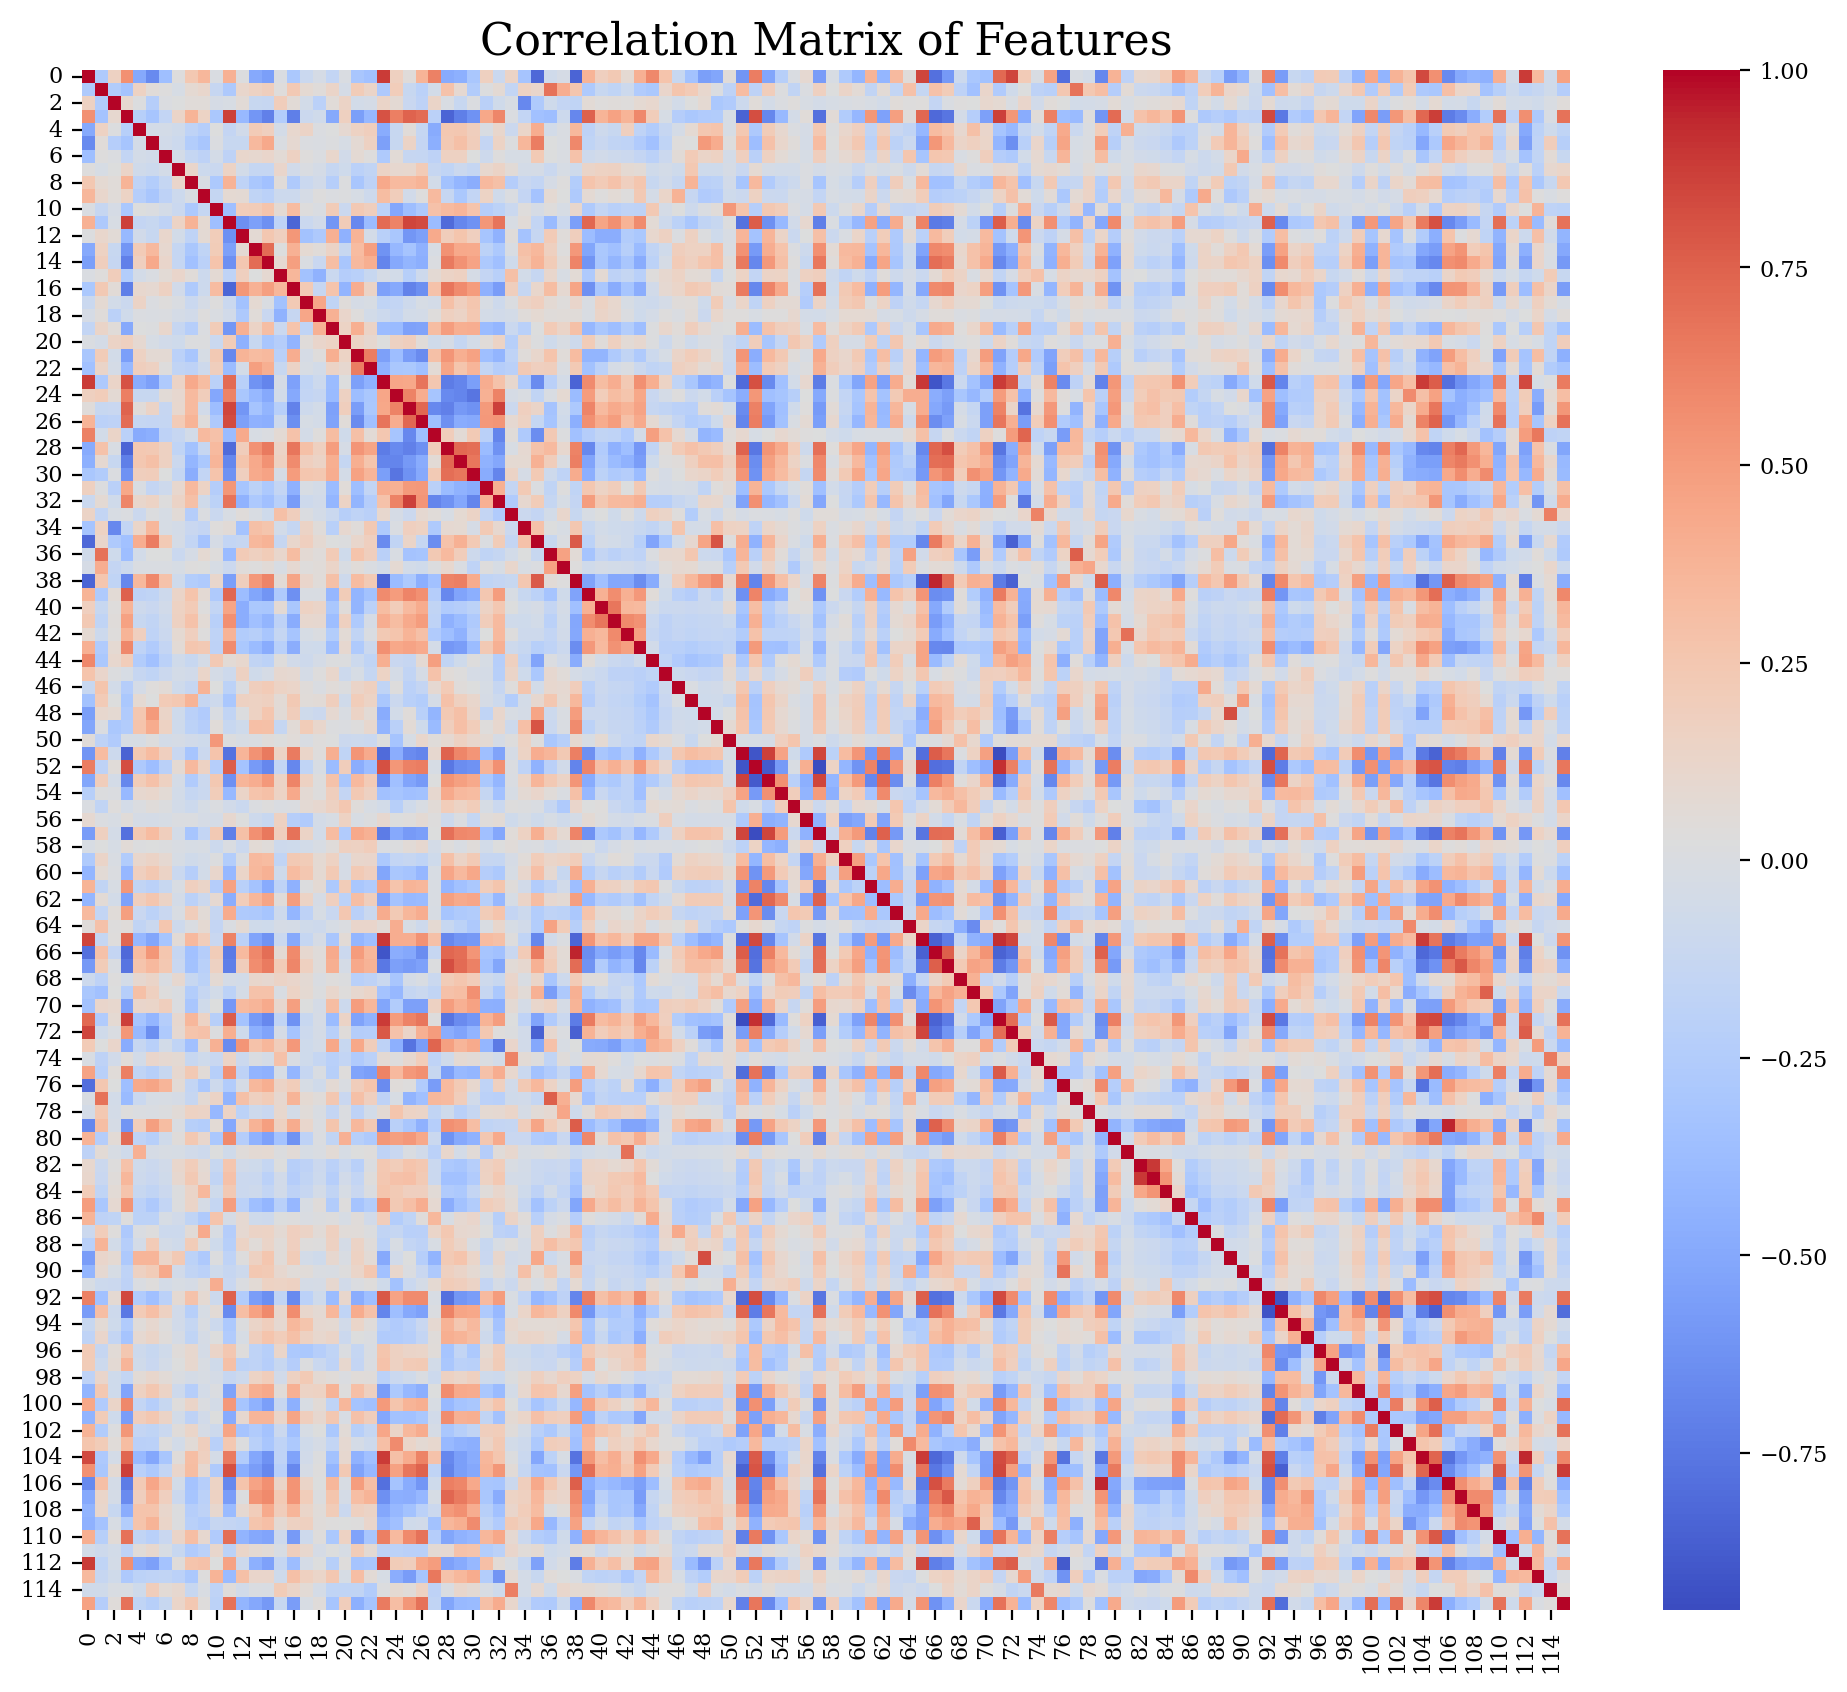

Highly correlated features:  {11, 16, 23, 25, 26, 28, 32, 35, 38, 51, 52, 53, 57, 62, 65, 66, 67, 71, 72, 75, 83, 89, 92, 93, 101, 104, 105, 106, 112, 115}


In [31]:
X_train_tsfel_corr_var = pd.DataFrame(X_train_tsfel_corr_var)
corr_matrix = X_train_tsfel_corr_var.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()

# Identify the features that are highly correlated with each other
corr_threshold = 0.8
highly_correlated_features = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = corr_matrix.columns[i]
            highly_correlated_features.add(colname)

print("Highly correlated features: ", highly_correlated_features)

No of Features: 561


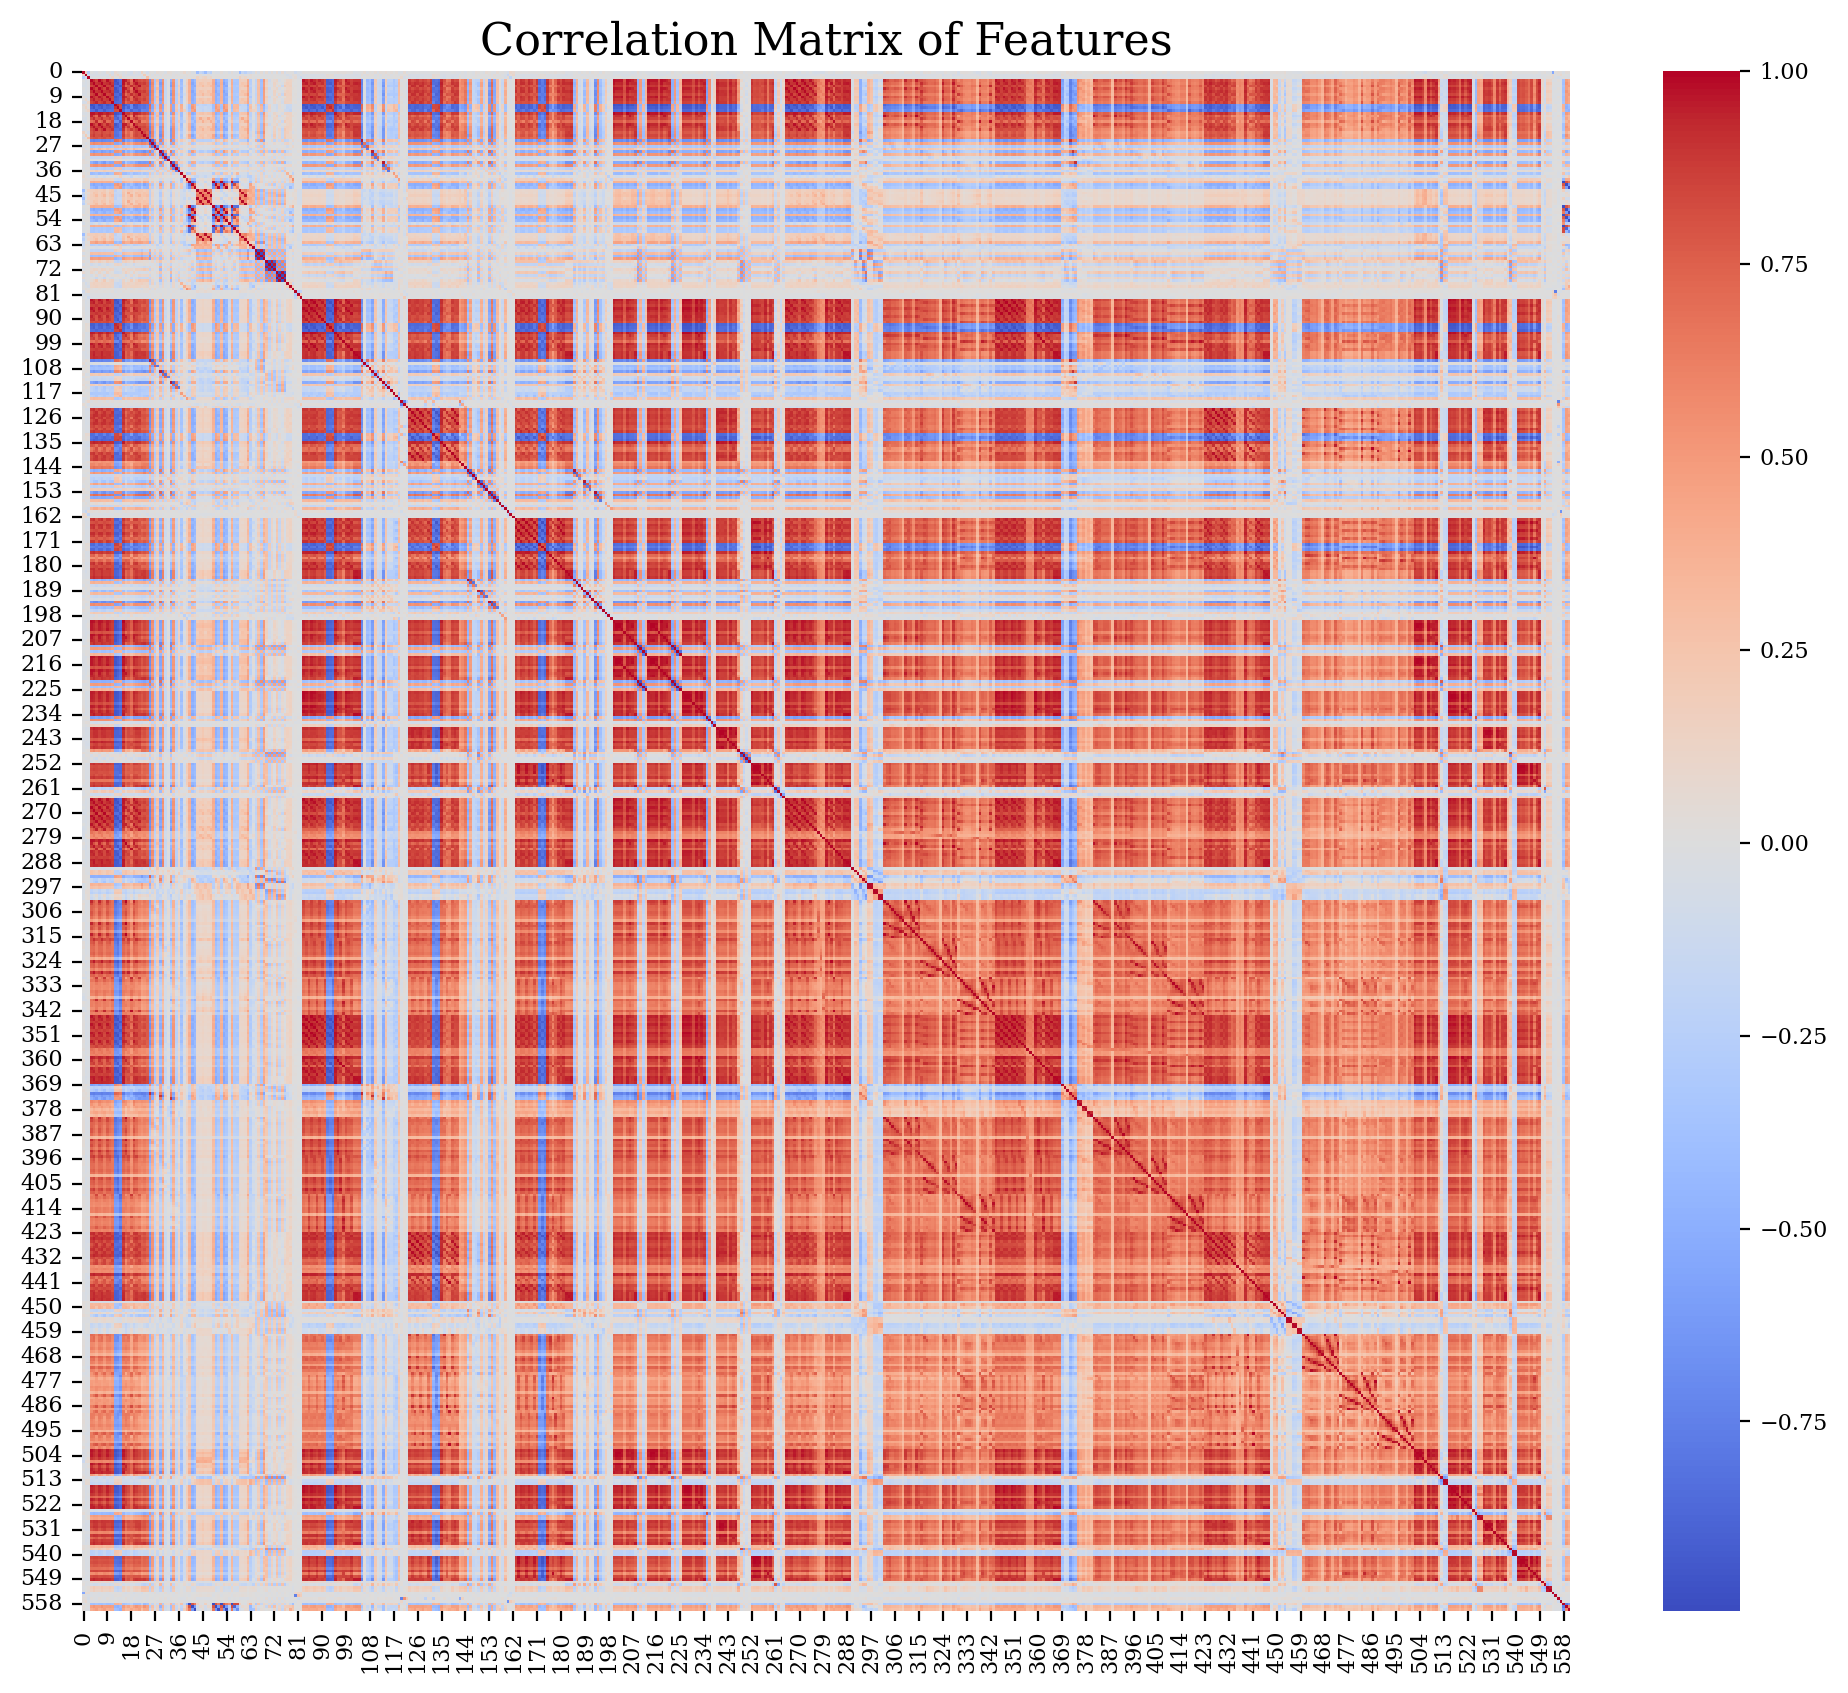

Highly correlated features: {'fBodyAccJerk-entropy()-Z', 'fBodyAccMag-entropy()', 'tBodyGyroJerk-min()-X', 'fBodyBodyGyroJerkMag-entropy()', 'tBodyAccJerk-std()-Y', 'fBodyBodyGyroJerkMag-std()', 'fBodyAcc-iqr()-X', 'fBodyAccMag-kurtosis()', 'fBodyGyro-sma()', 'fBodyAcc-mean()-Z', 'tBodyAccJerk-min()-Y', 'tBodyAccJerkMag-min()', 'fBodyAccJerk-bandsEnergy()-9,16', 'fBodyAccJerk-sma()', 'fBodyAcc-energy()-X', 'fBodyGyro-bandsEnergy()-17,32', 'fBodyAcc-bandsEnergy()-41,48', 'fBodyBodyAccJerkMag-entropy()', 'fBodyAccJerk-mad()-X', 'fBodyAccMag-energy()', 'tBodyGyroMag-min()', 'tBodyGyro-std()-X', 'fBodyAccJerk-kurtosis()-Y', 'tBodyAcc-std()-Z', 'fBodyAccMag-mean()', 'tGravityAcc-mad()-Y', 'fBodyGyro-bandsEnergy()-25,48', 'tBodyGyroJerk-energy()-Z', 'tBodyAcc-std()-Y', 'fBodyGyro-iqr()-Z', 'fBodyAccJerk-bandsEnergy()-41,48', 'tBodyGyro-sma()', 'fBodyAccJerk-std()-Y', 'fBodyGyro-bandsEnergy()-33,48', 'tBodyGyroJerkMag-sma()', 'fBodyAccJerk-energy()-Z', 'fBodyGyro-bandsEnergy()-1,24', 'angle(Z

In [37]:
UCI_features = list()
with open('../UCI HAR Dataset/features.txt') as f:
    UCI_features = [line.split()[1] for line in f.readlines()]

print('No of Features: {}'.format(len(UCI_features)))

UCI_X_train = pd.DataFrame(UCI_X_train)
corr_matrix = UCI_X_train.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, cmap='coolwarm', annot=False, fmt=".2f")
plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()

corr_threshold = 0.8
highly_correlated_features = set()

# Find pairs of highly correlated features and store the names
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i, j]) > corr_threshold:
            colname = UCI_features[i]
            highly_correlated_features.add(colname)

# Print the highly correlated features
print("Highly correlated features:", highly_correlated_features)